In [19]:
import pandas as pd
import numpy as np
import os
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
epsilon = 1e-07

In [4]:
with open('../inputs/hero_id_dict', 'rb') as f:
    hero_id_dict = pickle.load(f)

# read the inputs
df_heroes = pd.read_csv('../inputs/hero_data_processed.csv')
# correct the hero ids
df_heroes['hero_id'] = df_heroes['hero_id'].apply(lambda x: hero_id_dict[x])

df_train_full = []
for file in ['train9.csv', 'train1.csv', 'test9.csv']:
    df_temp = pd.read_csv('../inputs/' + file)
    df_train_full.append(df_temp.loc[:,:])

df_train_full = pd.concat(df_train_full)

# correct the hero ids in the dataset
df_train_full['hero_id'] = df_train_full['hero_id'].apply(lambda x: hero_id_dict[x])
# correct the user_id, decrease them by 1 so that user ids start from 0
df_train_full['user_id'] = df_train_full['user_id'].apply(lambda x: x - 1)

# prepare a dict to map column name to position
train_cols_dict = dict([[x, index] for index, x in enumerate(df_train_full.columns.tolist())])

# get the unique users
num_users = len(df_train_full['user_id'].unique())
num_heroes = len(df_heroes['hero_id'].unique())

df_test = pd.read_csv('../inputs/test1.csv')
df_test['user_id'] = df_test['user_id'].apply(lambda x: x - 1)
df_test['hero_id'] = df_test['hero_id'].apply(lambda x: hero_id_dict[x])

# create a matrix to store the target vaiable for
# different user X hero pairs
user_hero_kda_raw   = df_train_full.pivot_table(index = 'user_id', columns = 'hero_id', values = 'kda_ratio').fillna(0).as_matrix()
user_hero_num_games = df_train_full.pivot_table(index = 'user_id', columns = 'hero_id', values = 'num_games').fillna(0).as_matrix()
user_hero_num_wins  = df_train_full.pivot_table(index = 'user_id', columns = 'hero_id', values = 'num_wins').fillna(0).as_matrix()

user_hero_exist = np.clip(np.array(user_hero_num_games), a_min = 0, a_max = 1)

In [17]:
df_train = pd.merge(left = df_train_full, right = df_heroes, how = 'inner', on = 'hero_id')

## columns in the hero dataset
hero_id
base_health_regen
base_armor
base_magic_resistance
base_attack_min
base_attack_max
base_strength
base_agility
base_intelligence
strength_gain
agility_gain
intelligence_gain
attack_range
projectile_speed
attack_rate
move_speed
turn_rate
role_carry
role_disabler
role_durable
role_escape
role_initiator
role_jungler
role_nuker
role_pusher
role_support
primary_attr_agi
primary_attr_int
primary_attr_str
attack_type_melee
attack_type_ranged


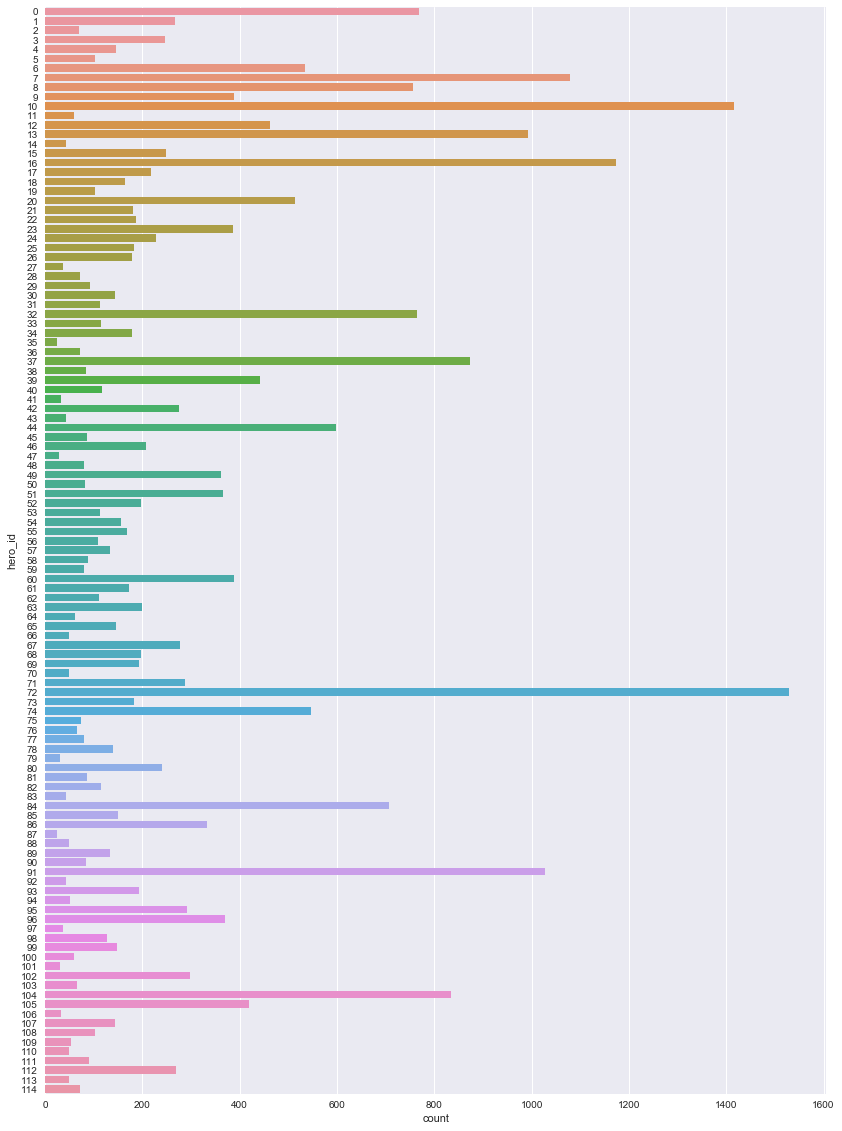

In [82]:
## study how many users are available per hero
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(14, 20))
sns.countplot(y = 'hero_id', data = df_train_full)
# sns.barplot(y = 'hero_id', x = 'kda_ratio', data = df_train_full, ax = axs[1])

In [58]:
## try grouping the heroes into different similar clusters
if 'cluster' in df_heroes.columns:
    df_heroes.drop('cluster', axis = 1, inplace = True)
kmeans = KMeans(n_clusters = 5, random_state = 42)
scaler = StandardScaler()
kmeans.fit(scaler.fit_transform(df_heroes.loc[:, [x for x in df_heroes.columns if x != 'hero_id']].as_matrix()))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [59]:
df_heroes['cluster'] = kmeans.predict(scaler.transform(df_heroes.loc[:, [x for x in df_heroes.columns if x != 'hero_id']].as_matrix()))

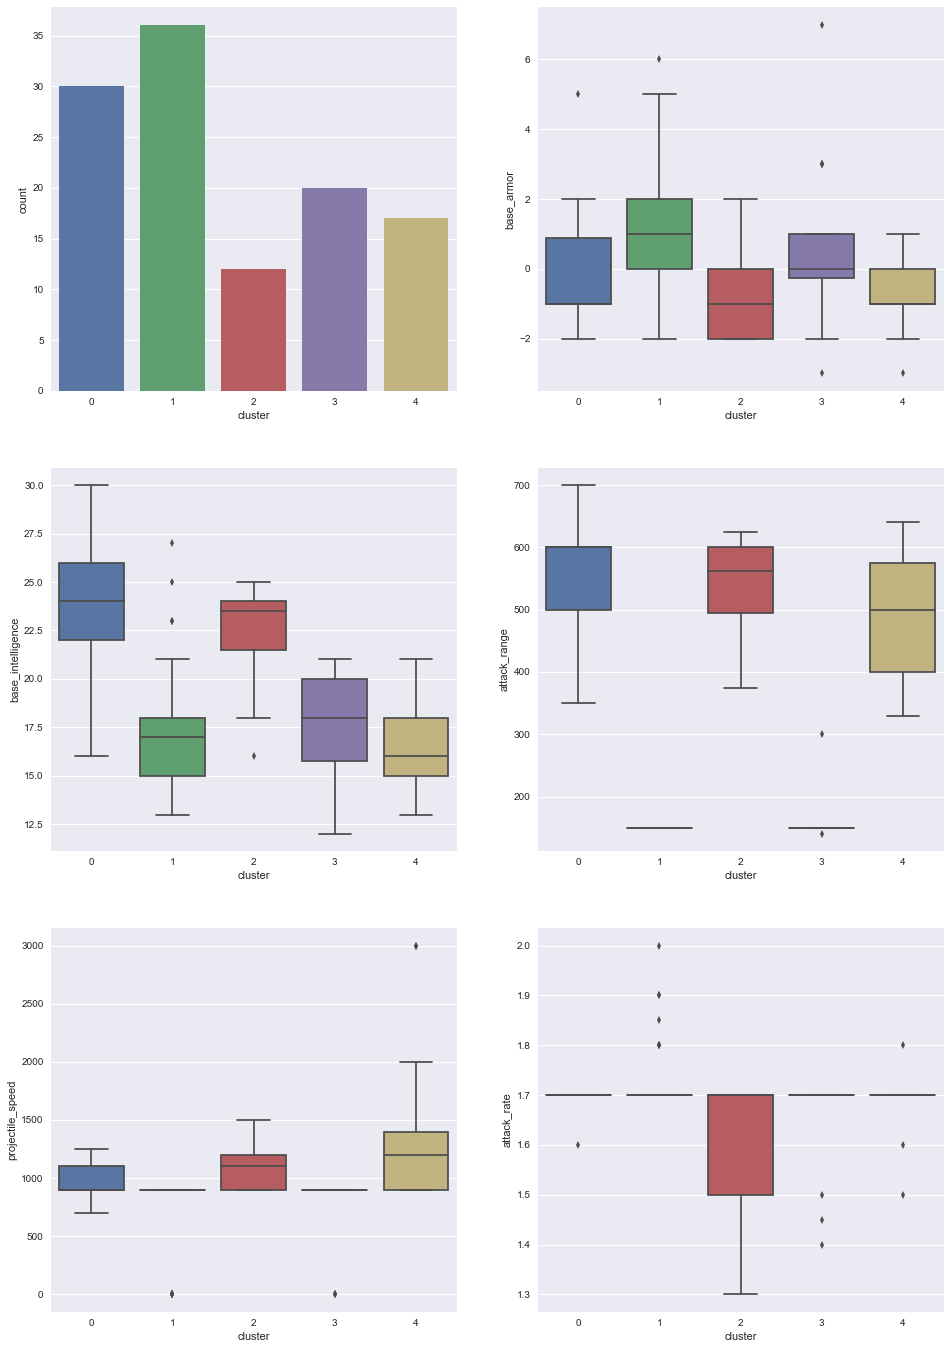

In [79]:
## study the clusters
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize=(16, 24))
sns.countplot(x = 'cluster', data = df_heroes, ax = axs[0][0])
sns.boxplot(x = 'cluster', y = 'base_armor', data = df_heroes, ax = axs[0][1])
sns.boxplot(x = 'cluster', y = 'base_intelligence', data = df_heroes, ax = axs[1][0])
sns.boxplot(x = 'cluster', y = 'attack_range', data = df_heroes, ax = axs[1][1])
sns.boxplot(x = 'cluster', y = 'projectile_speed', data = df_heroes, ax = axs[2][0])
sns.boxplot(x = 'cluster', y = 'attack_rate', data = df_heroes, ax = axs[2][1])

In [77]:
p1 = np.percentile(df_train_full['kda_ratio'], 1)
p99 = np.percentile(df_train_full['kda_ratio'], 99)
# print (p1, p99)
df_train_full['kda_ratio'] = df_train_full['kda_ratio'].clip(lower = p1, upper = p99, axis = 0)

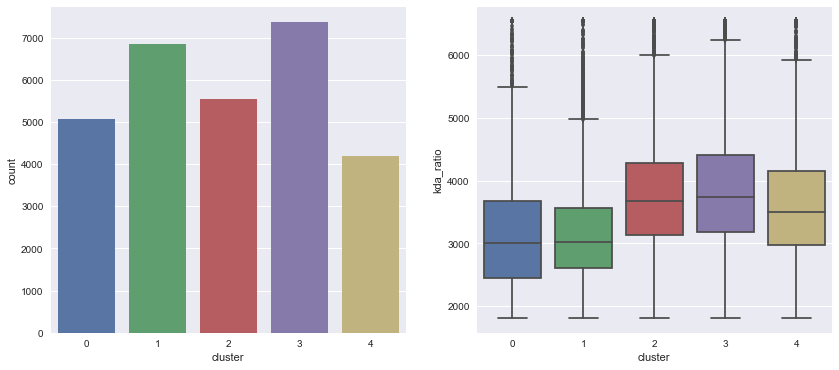

In [78]:
## observe how the hero counts vary with the clusters
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
sns.countplot(x = 'cluster', \
              data = pd.merge(left = df_train_full, right = df_heroes[['hero_id', 'cluster']], how = 'inner', on = 'hero_id'),\
              ax = axs[0])
sns.boxplot(x = 'cluster', y = 'kda_ratio', \
              data = pd.merge(left = df_train_full, right = df_heroes[['hero_id', 'cluster']], how = 'inner', on = 'hero_id'),\
              ax = axs[1])